<a href="https://colab.research.google.com/github/AndreasGeorgiou03/PINODEs/blob/main/PINODE_Exp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
pip install torchdiffeq

In [123]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchdiffeq import odeint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ============================================
# 1. Problem setup: 4-DOF
# ============================================

# Parameters (the same as previous experiment)
k1 = k2 = k3 = k4 = 10.0
c1 = c2 = c3 = c4 = 0.5
m1 = m2 = m3 = m4 = 1.0
k_nl_true = 2.0  # cubic nonlinearity

# Mass matrix (all ones -> identity)
M = torch.eye(4, device=device)

# Stiffness matrix K for a 4-DOF shear building (fixed base)
K = torch.tensor([
    [k1 + k2,   -k2,       0.0,      0.0],
    [-k2,       k2 + k3,  -k3,       0.0],
    [0.0,      -k3,       k3 + k4,  -k4],
    [0.0,       0.0,      -k4,       k4]
], dtype=torch.float32, device=device)

# Damping matrix (diagonal with c1..c4)
C = torch.diag(torch.tensor([c1, c2, c3, c4], dtype=torch.float32, device=device))

# Initial conditions for this experiment)
h0_1 = torch.tensor([ 2.0,  0.0, 0.0, 0.0,  0.0, -2.0, 0.0, 0.0], dtype=torch.float32, device=device)
h0_2 = torch.tensor([-2.0,  0.0, 0.0, 3.0, -2.0,  0.0, 0.0, 0.0], dtype=torch.float32, device=device)
h0_3 = torch.tensor([ 0.0,  4.0, 0.0, 0.0,  0.0,  0.0, 0.0, 0.0], dtype=torch.float32, device=device)
h0_4 = torch.tensor([ 0.0,  0.0, 0.0, 0.0,  0.0,  0.0, 0.0, 0.0], dtype=torch.float32, device=device)

h0_train = [h0_4]

# Time grids
dt = 0.01  # 100 Hz
t_train_end = 10.0
t_test_end = 8.0  # extrapolate to 8 seconds

t_train = torch.linspace(0.0, t_train_end, int(t_train_end / dt) + 1, device=device)
t_test  = torch.linspace(0.0, t_test_end,  int(t_test_end  / dt) + 1, device=device)



Using device: cpu


In [164]:
# ============================================
# 2. Forcing: white-noise-like excitation u(t)
# ============================================

torch.manual_seed(0) # this is for reproduction

num_freqs = 50
freqs = torch.linspace(0.5, 20.0, num_freqs, device=device)
phases = 2.0 * math.pi * torch.rand(num_freqs, device=device)
coeffs = torch.randn(num_freqs, device=device) / math.sqrt(num_freqs)

def u_base_fun(t):

    t = t.to(device)
    # Shape (..., 1) for broadcasting
    t_exp = t.unsqueeze(-1)
    arg = 2.0 * math.pi * freqs * t_exp + phases  # shape (..., num_freqs)
    # sum over frequencies
    return (coeffs * torch.sin(arg)).sum(dim=-1)

# Forcing distribution applied only at DOF 1
B_force = torch.tensor([1.0, 0.0, 0.0, 0.0], dtype=torch.float32, device=device)

# Amplitude levels
amplitudes_train = [12.5]

In [165]:
# ============================================
# 3. Ground-truth dynamics (with forcing)
# ============================================

def make_ground_truth_rhs(amp, u_fun):

    def rhs(t, h):
        x = h[:4]
        v = h[4:]

        # Linear restoring + damping
        lin_force = -K @ x - C @ v

        # Cubic nonlinearity on DOF 1 only
        f_nl = torch.zeros_like(x)
        f_nl[0] = -k_nl_true * x[0]**3

        # External forcing
        u_t = amp * u_fun(t)  # scalar
        f_u = B_force * u_t      # (4,)

        a = lin_force + f_nl + f_u  # since M = I

        dh = torch.zeros_like(h)
        dh[:4] = v
        dh[4:] = a
        return dh

    return rhs

@torch.no_grad()
def generate_trajectory(h0, t_grid, amp, u_fun):

    # make the groundtruth
    rhs = make_ground_truth_rhs(amp, u_fun)

    # simulate the trajectory
    sol = odeint(rhs, h0, t_grid, method='rk4')
    return sol

print("Generating ground truth training data (white-noise excitation)...")
traj_list = []  # shape [N_ic][n_amps]

# for all ICs and amplitutes, create the appropriate trajectory
for h0 in h0_train:
    for a in amplitudes_train:
        traj = generate_trajectory(h0, t_train, a, u_base_fun)
        assert traj.ndim == 2
        assert traj.shape[0] == len(t_train)
        assert traj.shape[1] == 8
        traj_list.append(traj)



# Example test case: unseen amplitude (extrapolation in input level)
amp_test = 15
traj_test_true = generate_trajectory(h0_2, t_test, amp_test, u_base_fun)

Generating ground truth training data (white-noise excitation)...


In [166]:
# ============================================
# 4. PINODE schemes (physics + neural discrepancy)
#    this is only for the fully physics-informed model
# ============================================

class PINODEFuncScheme3(nn.Module):

    def __init__(self, K, C, B):
        super().__init__()
        self.K = nn.Parameter(K.clone(), requires_grad=False)
        self.C = nn.Parameter(C.clone(), requires_grad=False)
        self.B = nn.Parameter(B.clone(), requires_grad=False)
        self.amp = 1.0 # this is only for initialization
        self.u_fun = lambda t: 0.0 # this is only for initialization

        # same as the previous experiment
        self.mlp = nn.Sequential(
            nn.Linear(8, 30),
            nn.Tanh(),
            nn.Linear(30, 4)
        )

    def forward(self, t, h):
        x = h[..., :4]
        v = h[..., 4:]

        dv_phys = (
            - self.K @ x.unsqueeze(-1)
            - self.C @ v.unsqueeze(-1)
        ).squeeze(-1)

        u_t = self.amp * self.u_fun(t)
        f_u = self.B * u_t
        dv_phys = dv_phys + f_u

        dv_corr = self.mlp(h)

        a = dv_phys + dv_corr

        dh = torch.zeros_like(h)
        dh[..., :4] = v
        dh[..., 4:] = a
        return dh

In [167]:
# ============================================
# 5. Discrepancy reference (with forcing)
# ============================================

def discrepancy_reference(x, v, t, scheme, K, C, k_nl, B, amp, u_fun):
    # Ensure x, v are 2D: (T, ndof) even if T=1
    if x.ndim == 1:
        x = x.unsqueeze(0)   # (1, ndof)
    if v.ndim == 1:
        v = v.unsqueeze(0)

    # nonlinear force only on DOF1
    f_nl = torch.zeros_like(x)
    f_nl[:, 0] = k_nl * x[:, 0]**3

    # linear part Kx + Cv (T,4)
    lin = torch.matmul(x, K.T) + torch.matmul(v, C.T)

    # external forcing
    u_vals = amp * u_fun(t)          # (T,)
    f_u = u_vals.unsqueeze(-1) * B.unsqueeze(0)  # (T,4)

    # true acceleration
    a_true = -(lin + f_nl) + f_u

    # scheme 1 and 2 are only for example purposes
    if scheme == 1:
        a_phy = f_u
    elif scheme == 2:
        a_phy = -0.7 * lin + f_u
    elif scheme == 3: # the only case that gets used
        a_phy = -lin + f_u
    else:
        raise ValueError("scheme must be 1, 2, or 3")

    a_disc = a_true - a_phy
    return a_disc

def true_discrepancy_on_traj(scheme, traj, t_grid, amp, u_fun):
    assert traj.ndim == 2, f"traj.ndim={traj.ndim}, expected 2"
    T, D = traj.shape
    assert D == 8, f"traj.shape={traj.shape}, expected (T,8)"
    assert t_grid.shape[0] == T, f"len(t_grid)={len(t_grid)}, T={T}"

    x = traj[:, :4]   # (T,4)
    v = traj[:, 4:]   # (T,4)

    disc = discrepancy_reference(x, v, t_grid,scheme=scheme, K=K, C=C,k_nl=k_nl_true, B=B_force, amp=amp, u_fun=u_fun)

    assert disc.shape == x.shape, (f"discrepancy_reference returned {disc.shape}, expected {x.shape}")
    return disc


In [168]:
def train_scheme_with_disc_multiIC_multiamp_sequential(scheme,model,h0_list,amplitudes,traj_list,t_train,u_fun,num_epochs=4000,lr=1e-3,lambda_disc=1.0,):

    # transfer the model to the device
    model = model.to(device)

    # assign the white noise of the training
    model.u_fun = u_fun
    model.train()

    # optimizer
    opt = optim.Adam(model.parameters(), lr=lr)

    # loss function
    mse = nn.MSELoss()

    n_ics  = len(h0_list)
    n_amps = len(amplitudes)

    assert len(traj_list) == n_ics * n_amps

    total_pairs     = n_ics * n_amps
    epochs_per_pair = num_epochs // total_pairs
    leftover        = num_epochs - epochs_per_pair * total_pairs

    print(f"Training on {n_ics} ICs × {n_amps} amplitudes = {total_pairs} pairs")
    print(f"{epochs_per_pair} epochs per pair, leftover {leftover} epoch(s)")

    global_epoch = 0

    # index for assigning the leftovers epoch in the last loop
    pair_index   = 0

    i_ic = 0

    # only one IC for training (in this example)
    h0 = h0_list[0]

    for j_amp, a in enumerate(amplitudes_train):
        h0 = h0.to(device)

        # flatten the id
        flat_idx  = i_ic * n_amps + j_amp
        traj_true = traj_list[flat_idx].to(device)

        # STATE SHAPE ASSERT
        assert traj_true.ndim == 2, f"traj_true[{flat_idx}].ndim={traj_true.ndim}"
        assert traj_true.shape[0] == len(t_train), (f"traj_true[{flat_idx}].shape={traj_true.shape}, len(t_train)={len(t_train)}")
        assert traj_true.shape[1] == 8, (f"traj_true[{flat_idx}].shape={traj_true.shape}, expected 8 state dims")

        pair_index += 1
        this_epochs = epochs_per_pair + (leftover if pair_index == total_pairs else 0)

        print(f"\n=== Training on IC {i_ic}, amplitude {a} "f"for {this_epochs} epochs (scheme {scheme}) ===")

        for local_epoch in range(1, this_epochs + 1):
            global_epoch += 1
            opt.zero_grad()

            model.amp = float(a)

            # STATE LOSS
            # measures the trajectory loss between the observed data and the predicted trajectory
            pred = odeint(model, h0, t_train, method="rk4")  # (T, 8)

            assert pred.shape == traj_true.shape, (f"pred.shape={pred.shape}, traj_true.shape={traj_true.shape}")
            loss_state = mse(pred, traj_true)

            # DISCREPANCY LOSS
            # measures the loss between the true discrepancy and the predicted discrepancy
            with torch.no_grad():
                disc_true = true_discrepancy_on_traj(scheme, traj_true, t_train, a, model.u_fun)

            # query the model -> get predicted discrepancy
            disc_nn = model.mlp(traj_true)

            # DISC SHAPE ASSERT
            assert disc_true.shape == disc_nn.shape, (f"disc_true.shape={disc_true.shape}, disc_nn.shape={disc_nn.shape}")

            loss_disc = mse(disc_nn, disc_true)

            # overall loss
            loss = loss_state + lambda_disc * loss_disc

            # backpropagate
            loss.backward()

            # update weights
            opt.step()

            if local_epoch == 1 or global_epoch % 100 == 0:
                print(f"[S{scheme}] Global {global_epoch:4d}, "f"IC={i_ic}, amp={a}, "f"state={loss_state.item():.4e}, "f"disc={loss_disc.item():.4e}, "f"total={loss.item():.4e}")
    return model


@torch.no_grad()
def evaluate_scheme_on_amp(scheme_name, model, amp_eval):
    loss_fn = nn.MSELoss()
    model.amp = float(amp_eval)

    # Predict
    pred = odeint(model, h0_2, t_test, method='rk4')

    mse_full = loss_fn(pred, traj_test_true).item()

    # split at 4s
    mid_idx = len(t_train)  # since t_train ends at 4s with same dt
    mse_0_4  = loss_fn(pred[:mid_idx], traj_test_true[:mid_idx]).item()
    mse_4_8  = loss_fn(pred[mid_idx:], traj_test_true[mid_idx:]).item()

    print(f"\n=== Evaluation for {scheme_name} (amp = {amp_eval}) ===")
    print(f"MSE 0–8s  : {mse_full:.4e}")
    print(f"MSE 0–4s  : {mse_0_4:.4e}")
    print(f"MSE 4–8s  : {mse_4_8:.4e}")


def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Saved model to {path}")

In [ ]:
# ============================================
# 7. Main: train scheme 3 (second experiment)
# ============================================

if __name__ == "__main__":

    # and that the folder exists.
    save_path = "/content/drive/MyDrive/pinode_models/"


    # Scheme 3
    model3 = PINODEFuncScheme3(K, C, B_force)
    model3.load_state_dict(torch.load(save_path + "scheme_3_white_noise_exp2_sICV4.pth", map_location=device))


    model3 = train_scheme_with_disc_multiIC_multiamp_sequential(
      scheme=3,
      model=model3,
      h0_list=h0_train,
      amplitudes=amplitudes_train,
      traj_list=traj_list,
      t_train=t_train,
      num_epochs=2000,
      u_fun=u_base_fun,
      lr=1e-3,
      lambda_disc=1.0,
    )
    # evaluate_scheme_on_amp("Scheme 3", model3, amp_test)
    save_model(model3, save_path + "scheme_3_white_noise_exp2_sICV4.pth")

Training on 1 ICs × 1 amplitudes = 1 pairs
2000 epochs per pair, leftover 0 epoch(s)

=== Training on IC 0, amplitude 12.5 for 2000 epochs (scheme 3) ===
[S3] Global    1, IC=0, amp=12.5, state=2.0141e-07, disc=6.3990e-06, total=6.6004e-06


In [114]:
# evaluate_scheme_on_amp("Scheme 3", model3, amp_test)
save_model(model3, save_path + "scheme_3_white_noise_exp2_sICV4.pth")

Saved model to /content/drive/MyDrive/pinode_models/scheme_3_white_noise_exp2_sICV4.pth


In [24]:
import matplotlib.pyplot as plt
import torch

def plot_x1_v1_a1(t, gt, pred, dt=0.01, save_path=None):

    # Extract x1 and v1
    x1_gt = gt[:, 0].detach().cpu()
    v1_gt = gt[:, 4].detach().cpu()

    x1_pr = pred[:, 0].detach().cpu()
    v1_pr = pred[:, 4].detach().cpu()

    # Numerical acceleration a1 via forward diff
    a1_gt = torch.diff(v1_gt) / dt
    a1_gt = torch.cat((a1_gt[:1], a1_gt), dim=0)  # pad to same length

    a1_pr = torch.diff(v1_pr) / dt
    a1_pr = torch.cat((a1_pr[:1], a1_pr), dim=0)

    # Plot
    plt.figure(figsize=(12, 9))

    # x1(t)
    plt.subplot(3, 1, 1)
    plt.plot(t.cpu(), x1_gt, 'k', lw=2, label="GT x1")
    plt.plot(t.cpu(), x1_pr, 'g--', lw=1.5, label="Pred x1")
    plt.ylabel("x1(t)")
    plt.grid(True)
    plt.legend()

    # v1(t)
    plt.subplot(3, 1, 2)
    plt.plot(t.cpu(), v1_gt, 'k', lw=2, label="GT v1")
    plt.plot(t.cpu(), v1_pr, 'g--', lw=1.5, label="Pred v1")
    plt.ylabel("v1(t)")
    plt.grid(True)
    plt.legend()

    # a1(t)
    plt.subplot(3, 1, 3)
    plt.plot(t.cpu(), a1_gt, 'k', lw=2, label="GT a1")
    plt.plot(t.cpu(), a1_pr, 'g--', lw=1.5, label="Pred a1")
    plt.ylabel("a1(t)")
    plt.xlabel("Time (s)")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=250)

    plt.show()


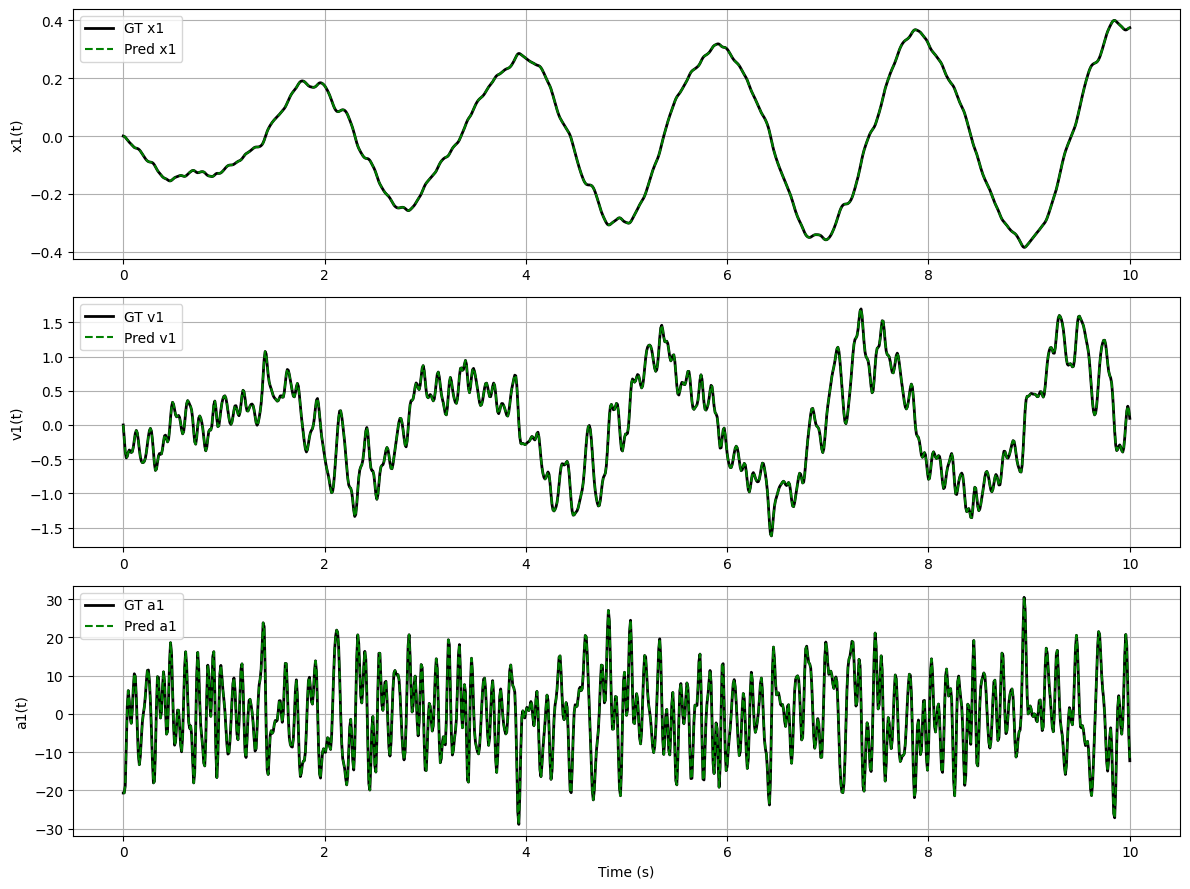

In [126]:
traj_gt = traj_list[3]
model3.amp = float(amplitudes_train[3])
model3.u_fun = u_base_fun
traj_pred = odeint(model3, h0_train[0], t_train, method='rk4')

plot_x1_v1_a1(t_train, traj_gt, traj_pred, dt=dt)


In [26]:
pip install pysindy

In [32]:
import pysindy as ps

def build_sindy_discrepancy_exp2(h_true_list,amp_list,scheme,K_true,C_true,k_nl_true,B_force,t_grid,u_fun,device="cpu"):

    K = K_true.to(device)
    C = C_true.to(device)
    B = B_force.to(device)
    t_grid = t_grid.to(device)

    X_list = []
    Y_list = []

    for traj, amp in zip(h_true_list, amp_list):
        h_true = traj.to(device)   # (T,8)
        x = h_true[:, :4]
        v = h_true[:, 4:]

        # discrepancy for this trajectory & amplitude
        a_disc = discrepancy_reference(x, v, t_grid, scheme, K, C, k_nl_true, B, amp, u_fun)  # (T,4)

        X_list.append(h_true)
        Y_list.append(a_disc)

    X_all = torch.cat(X_list, dim=0)
    Y_all = torch.cat(Y_list, dim=0)

    X = X_all.cpu().numpy()  # (N,8)
    Y = Y_all.cpu().numpy()  # (N,4)

    return X, Y


In [33]:
def run_sindy_discrepancy_exp2(h_true_list,amp_list,scheme,K_true,C_true,k_nl_true,B_force,t_grid, u_fun,dt,threshold=0.05,device="cpu"):

    # Build data
    X, Y = build_sindy_discrepancy_exp2(h_true_list=h_true_list,amp_list=amp_list,scheme=scheme,K_true=K_true,C_true=C_true,k_nl_true=k_nl_true,B_force=B_force,t_grid=t_grid,u_fun=u_fun,device=device)
    # X: (N,8) state h = [x1..x4, v1..v4]
    # Y: (N,4) discrepancy accelerations

    # Polynomial library (like before)
    poly_lib = ps.PolynomialLibrary(degree=3,include_interaction=False,include_bias=False)

    # Optimizer
    optimizer = ps.STLSQ(threshold=threshold, alpha=1e-5, max_iter=100)

    # Fit 4 independent SINDy models, one per DOF discrepancy
    print(f"\n===== SINDy discrepancy equations for Scheme {scheme} (Experiment 2) =====")

    feature_names = ['x1','x2','x3','x4','v1','v2','v3','v4']

    for i in range(4):
        y_i = Y[:, i:i+1]   # (N,1)

        model = ps.SINDy(feature_library=poly_lib,optimizer=optimizer,)
        model.fit(X, t=dt, x_dot=y_i)

        coeffs = model.coefficients()[0]
        feats  = model.get_feature_names()

        print(f"\n--- dv{i+1}_disc ---")
        terms = []
        for c, term in zip(coeffs, feats):
            if abs(c) > 1e-9:
                terms.append(f"{c:+.5f} * {term}")
        if len(terms) == 0:
            print("   0")
        else:
            print("   dv{} = ".format(i+1) + " ".join(terms))


In [163]:
dt = 0.01

sindy_disc_s2 = run_sindy_discrepancy_exp2(h_true_list=traj_list,amp_list=amplitudes_train,scheme=3,K_true=K,C_true=C,k_nl_true=k_nl_true,B_force=B_force,t_grid=t_train,u_fun=u_base_fun,dt=dt,threshold=0.01,device=device)



===== SINDy discrepancy equations for Scheme 3 (Experiment 2) =====

--- dv1_disc ---
   dv1 = -2.00000 * x0^3

--- dv2_disc ---
   0

--- dv3_disc ---
   0

--- dv4_disc ---
   0


In [35]:
def build_sindy_discrepancy_from_nn_exp2(h_true_list, model, device="cpu"):

    # Concatenate all trajectories
    # h_true = torch.cat(h_true_list, dim=0).to(device)   # (N,8)

    with torch.no_grad():
        a_disc_nn = model.mlp(h_true_list)                   # (N,4)

    X = h_true_list.cpu().numpy()
    Y = a_disc_nn.cpu().numpy()

    return X, Y


In [36]:
import pysindy as ps

def run_sindy_discrepancy_from_nn_exp2(h_true_list,model,dt,threshold=0.01,device="cpu"):


    # 1) Build X,Y from the trained neural net
    X, Y = build_sindy_discrepancy_from_nn_exp2(h_true_list=h_true_list,model=model,device=device)

    # 2) Same polynomial library as remainder of your code
    poly_lib = ps.PolynomialLibrary(degree=3,include_interaction=False,include_bias=False)

    # 3) Sparse optimizer
    optimizer = ps.STLSQ(threshold=threshold, alpha=1e-5, max_iter=1000)

    print("\n===== SINDy discrepancy equations from NN (Scheme 3 — Experiment 2) =====")

    sindy_models = []
    for i in range(4):
        y_i = Y[:, i:i+1]   # column i

        model_sindy = ps.SINDy(feature_library=poly_lib,optimizer=optimizer,)

        # Fit SINDy using NN-produced derivative y_i
        model_sindy.fit(X, t=dt, x_dot=y_i)
        sindy_models.append(model_sindy)

        coeffs = model_sindy.coefficients()[0]
        feats  = model_sindy.get_feature_names()

        print(f"\n--- dv{i+1}_disc (NN) ---")
        terms = []
        for c, term in zip(coeffs, feats):
            if abs(c) > 1e-9:
                terms.append(f"{c:+.5f} * {term}")
        if not terms:
            print("   0")
        else:
            print("   dv{} = ".format(i+1) + " ".join(terms))

    return sindy_models


In [162]:
models_s3_nn = run_sindy_discrepancy_from_nn_exp2(h_true_list=traj_list[3],model=model3,dt=dt,threshold=0.1, device=device)



===== SINDy discrepancy equations from NN (Scheme 3 — Experiment 2) =====

--- dv1_disc (NN) ---
   dv1 = -0.15915 * x2^2 -1.95195 * x0^3 -0.59133 * x2^3

--- dv2_disc (NN) ---
   0

--- dv3_disc (NN) ---
   0

--- dv4_disc (NN) ---
   0


/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(


In [43]:
torch.manual_seed(0)

num_freqs = 70
freqs  = torch.linspace(0.5, 30.0, num_freqs, device=device)
phases = 2.0 * math.pi * torch.rand(num_freqs, device=device)
coeffs = torch.randn(num_freqs, device=device) / math.sqrt(num_freqs)

def u_fun_cos(t):
    t = t.to(device)
    t_exp = t.unsqueeze(-1)
    arg = 2.0 * math.pi * freqs * t_exp + phases
    return (coeffs * torch.cos(arg)).sum(dim=-1)


In [129]:
# Example: use IC 0 and amplitude 10.0
amp_test = 12.5
h0 = h0_train[0]
dt = 0.01
t_test_end = 20
t_test  = torch.linspace(0.0, t_test_end,  int(t_test_end  / dt) + 1, device=device)

# GT RHS with the new noise
rhs_test = make_ground_truth_rhs(amp_test, u_fun_cos)

# generate GT trajectory
gt_test = odeint(rhs_test, h0, t_test)   # (T, 8)


In [130]:
model3.u_fun = u_fun_cos     # assign the new forcing to the model
model3.amp   = amp_test       # same amplitude as GT
pred_test = odeint(model3, h0, t_test, method="rk4")


In [131]:
# Displacement x1
x1_gt   = gt_test[:, 0].detach().cpu().numpy()
x1_pred = pred_test[:, 0].detach().cpu().numpy()

# Velocity v1
v1_gt   = gt_test[:, 4].detach().cpu().numpy()
v1_pred = pred_test[:, 4].detach().cpu().numpy()

t_np = t_test.detach().cpu().numpy()



In [132]:
a1_gt_list   = []
a1_pred_list = []

with torch.no_grad():
    # ground-truth rhs for this amp + forcing
    rhs_gt = make_ground_truth_rhs(amp_test, u_fun_cos)

    for k, t_k in enumerate(t_test):
        # GT acceleration
        dh_gt   = rhs_gt(t_k, gt_test[k])     # (8,)
        a1_gt   = dh_gt[4]                    # index 4 = a1
        a1_gt_list.append(a1_gt.item())

        # Model acceleration
        dh_pred = model3(t_k, pred_test[k])   # (8,)
        a1_pred = dh_pred[4]                  # index 4 = a1
        a1_pred_list.append(a1_pred.item())

a1_gt   = np.array(a1_gt_list)
a1_pred = np.array(a1_pred_list)


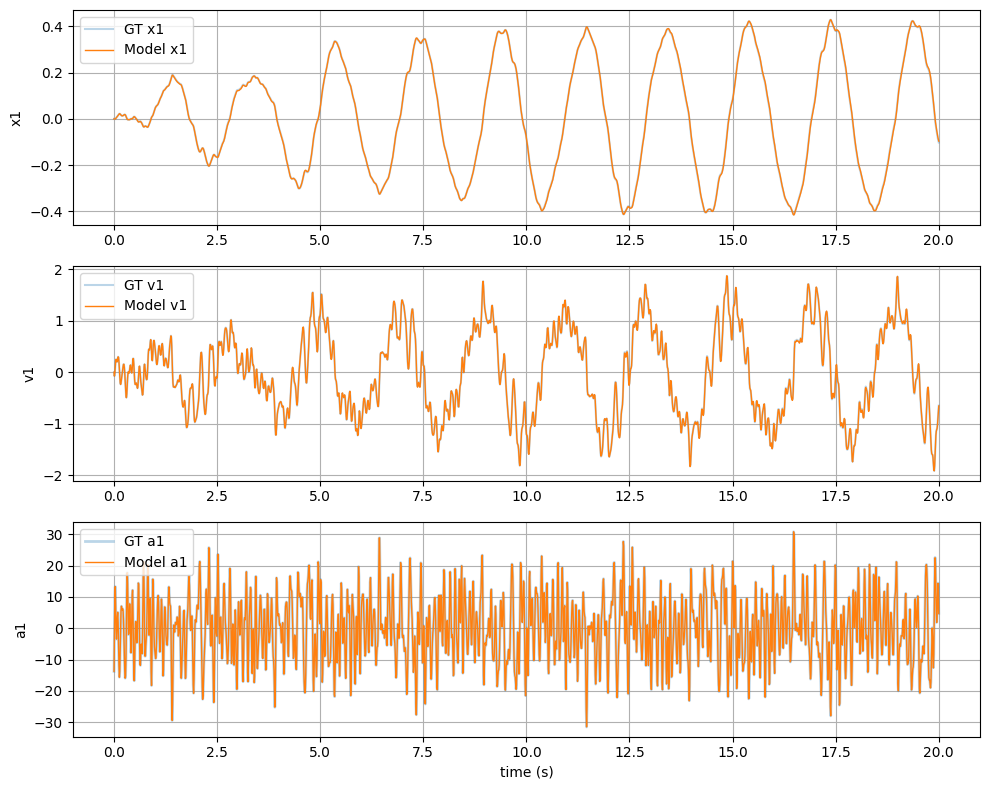

In [135]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# x1
plt.subplot(3,1,1)
plt.plot(t_np, x1_gt,   label="GT x1",   alpha=0.3)
plt.plot(t_np, x1_pred, label="Model x1", lw=1)
plt.ylabel("x1")
plt.grid(True)
plt.legend()

# v1
plt.subplot(3,1,2)
plt.plot(t_np, v1_gt,   label="GT v1",   alpha=0.3)
plt.plot(t_np, v1_pred, label="Model v1", lw=1)
plt.ylabel("v1")
plt.grid(True)
plt.legend()

# a1
plt.subplot(3,1,3)
plt.plot(t_np, a1_gt, label="GT a1",   alpha=0.3, lw=2)
plt.plot(t_np, a1_pred, label="Model a1", lw=1)
plt.xlabel("time (s)")
plt.ylabel("a1")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [145]:
import numpy as np
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

data = np.loadtxt("/content/drive/MyDrive/elcentro_NS.dat")

dt_ec = 0.02  # assume 0.02s unless the file says otherwise

if data.ndim == 1:
    acc_ec = data
    t_ec = np.arange(len(acc_ec)) * dt_ec
else:
    t_ec = data[:, 0]
    acc_ec = data[:, 1]

# acc_ec = -acc_ec

t_ec_torch   = torch.tensor(t_ec,    dtype=torch.float32, device=device)
acc_ec_torch = torch.tensor(acc_ec,  dtype=torch.float32, device=device)


def make_timeseries_fun(t_vec, u_vec):
    dt = (t_vec[1] - t_vec[0]).item()
    t0 = t_vec[0].item()
    t_end = t_vec[-1].item()
    N  = t_vec.numel()

    def u_fun(t):
        if t > t_end:
            return torch.tensor(0.0, device=t.device, dtype=u_vec.dtype)
        idx = ((t - t0) / dt).long()
        idx = torch.clamp(idx, 0, N - 1)
        return u_vec[idx]
    return u_fun

u_fun_elcentro = make_timeseries_fun(t_ec_torch, acc_ec_torch)


In [158]:
# Use the same dt and horizon as the record
t_test_end = 40
t_test  = torch.linspace(0.0, t_test_end,  int(t_test_end  / dt_ec) + 1, device=device)
h0 = h0_4                        # since model3 was trained on this IC
amp_test = 125                  # or any scalar scaling you want

# Ground-truth trajectory under El Centro forcing
rhs_test = make_ground_truth_rhs(amp_test, u_fun_elcentro)
gt_test  = odeint(rhs_test, h0, t_test, method="rk4")   # (T, 8)

# Model prediction under the same forcing
model3.u_fun = u_fun_elcentro
model3.amp   = amp_test
pred_test    = odeint(model3, h0, t_test, method="rk4")


In [159]:
import numpy as np

# 1) time
t_np = t_test.detach().cpu().numpy()

# 2) x1, v1
x1_gt   = gt_test[:, 0].detach().cpu().numpy()
x1_pred = pred_test[:, 0].detach().cpu().numpy()

v1_gt   = gt_test[:, 4].detach().cpu().numpy()
v1_pred = pred_test[:, 4].detach().cpu().numpy()

# 3) a1 via RHS (same pattern you used before)
a1_gt_list   = []
a1_pred_list = []

with torch.no_grad():
    rhs_gt = make_ground_truth_rhs(amp_test, u_fun_elcentro)

    for k, t_k in enumerate(t_test):
        dh_gt   = rhs_gt(t_k, gt_test[k])
        a1_gt_list.append(dh_gt[4].item())

        dh_pred = model3(t_k, pred_test[k])
        a1_pred_list.append(dh_pred[4].item())

a1_gt   = np.array(a1_gt_list)
a1_pred = np.array(a1_pred_list)


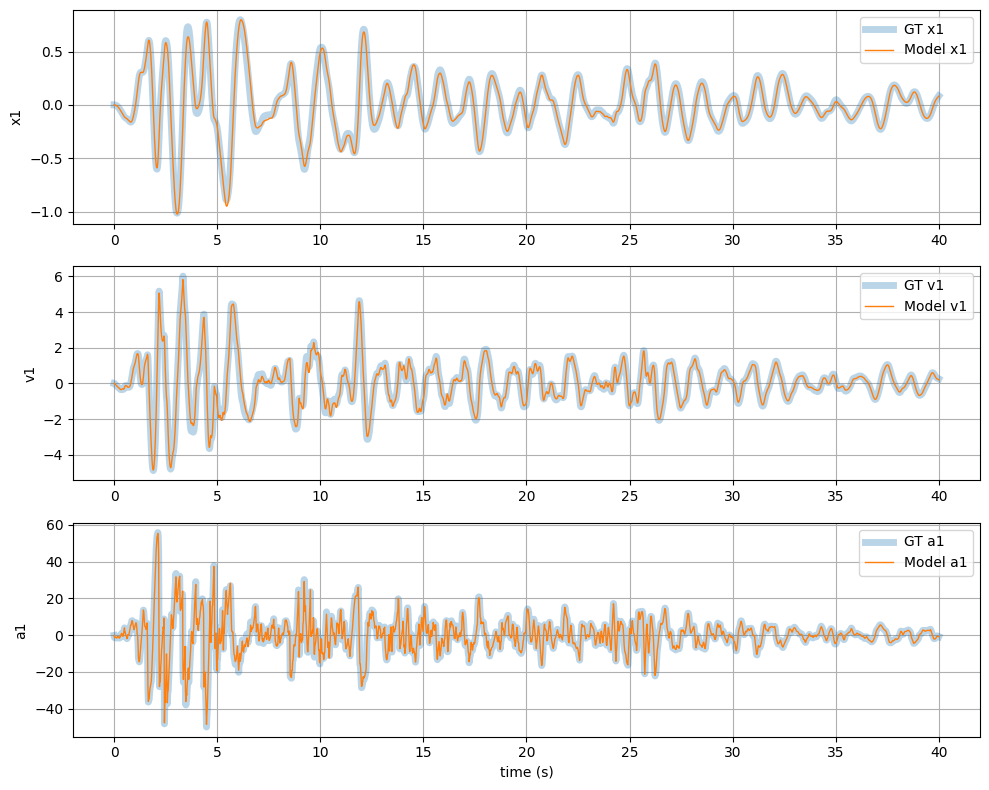

In [160]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# x1
plt.subplot(3,1,1)
plt.plot(t_np, x1_gt,   label="GT x1",   alpha=0.3, lw=5)
plt.plot(t_np, x1_pred, label="Model x1", lw=1)
plt.ylabel("x1")
plt.grid(True)
plt.legend()

# v1
plt.subplot(3,1,2)
plt.plot(t_np, v1_gt,   label="GT v1",   alpha=0.3, lw=5)
plt.plot(t_np, v1_pred, label="Model v1", lw=1)
plt.ylabel("v1")
plt.grid(True)
plt.legend()

# a1
plt.subplot(3,1,3)
plt.plot(t_np, a1_gt,   label="GT a1",   alpha=0.3, lw=5)
plt.plot(t_np, a1_pred, label="Model a1", lw=1)
plt.xlabel("time (s)")
plt.ylabel("a1")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
